<a href="https://colab.research.google.com/github/ginelledsouza/Health-Check/blob/master/Health_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Health Check - Chest X-ray 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import cv2

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from matplotlib.image import imread
from PIL import Image

#Data Loading and Transformation 

The data available to us are training, testing, and validation. we merge the training and validation data as of now and will split them into a proportion of 80-20 for data modeling

In [3]:
labels = ['NORMAL','PNEUMONIA']
Train = '/content/chest_xray/train'
Validate = '/content/chest_xray/val'
Data = [Train,Validate]
Training = []
TrainingLabels = []

for data in Data:
  for label in labels: 
    path = os.path.join(data, label)
    classlabel = labels.index(label)
    for img in os.listdir(path):
      image = cv2.imread(os.path.join(path, img), 0)
      image = cv2.resize(image,(200,200))
      Training.append(image)
      TrainingLabels.append(classlabel)

In [4]:
Test = '/content/chest_xray/test' 
Testing = []
TestingLabels = []

for label in labels: 
  path = os.path.join(Test, label)
  classlabel = labels.index(label)
  for img in os.listdir(path):
    image = cv2.imread(os.path.join(path, img), 0)
    image = cv2.resize(image,(200,200))
    Testing.append(image)
    TestingLabels.append(classlabel)

Healthy X-Ray: 1349
X-Ray with Pneumonia: 3883



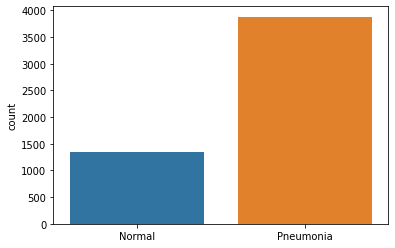

In [5]:
count = []

for i in TrainingLabels:
    if(i == 0):
        count.append("Normal")
    else:
        count.append("Pneumonia")

values, counts = np.unique(count, return_counts=True)
print('Healthy X-Ray: {}\nX-Ray with Pneumonia: {}\n'.format(counts[0],counts[1]))

sns.countplot(count)

We notice that the number of chest Xrays that are affected by pneumonia is much more than that not affected. Therefore, it is necessary to normalize our data.

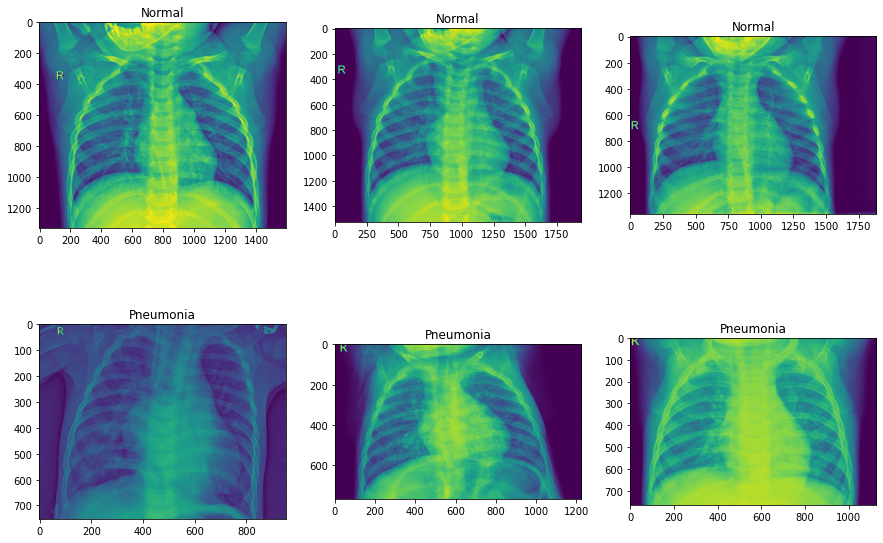

In [6]:
def Normal(pic=None):
  RandomNormalNo = np.random.randint(0,len(Train+ r'/NORMAL'))
  RandomNormalPic = os.listdir(Train+ r'/NORMAL')[RandomNormalNo]
  return RandomNormalPic

def Pneumonia(pic=None):
  RandomPneumoniaNo = np.random.randint(0,len(Train+ r'/PNEUMONIA'))
  RandomPneumoniaPic = os.listdir(Train+ r'/PNEUMONIA')[RandomPneumoniaNo]
  return RandomPneumoniaPic

plt.figure(figsize=(15,10))

for i in range(1,4):
  plt.subplot(2,3,i)
  plt.title('Normal')
  Picture = Image.open(Train + r'/NORMAL' + r'/' + Normal())
  plt.imshow(Picture)

for i in range(4,7):
  plt.subplot(2,3,i)
  plt.title('Pneumonia')
  Picture = Image.open(Train + r'/PNEUMONIA' + r'/' + Pneumonia())
  plt.imshow(Picture)


We convert our data into numpy arrays and split our training data into 80% training and 20% validation set.

In [7]:
Training = np.array(Training)
TrainingLabels = np.array(TrainingLabels)

Testing = np.array(Testing)
TestingLabels = np.array(TestingLabels)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(Training, TrainingLabels, test_size=0.2)

In [9]:
print('The Training set contains {} records with the shape {}\nThe Validation set contains {} records with the shape {}\nThe Testing set contains {} records with the shape {}'.format
      (X_train.shape[0],X_train.shape[1:],X_test.shape[0],X_test.shape[1:],Testing.shape[0],Testing.shape[1:]))

The Training set contains 4185 records with the shape (200, 200)
The Validation set contains 1047 records with the shape (200, 200)
The Testing set contains 624 records with the shape (200, 200)


In [10]:
def ImgProcessing(img):
    img = img/255
    return img

X_train= np.array(list(map(ImgProcessing,X_train)))
X_test= np.array(list(map(ImgProcessing,X_test)))
Testing = np.array(list(map(ImgProcessing,Testing)))

In [11]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
Testing = Testing.reshape(Testing.shape[0],Testing.shape[1],Testing.shape[2],1)

Before training any image predictive model it is always nescessary to perform certain image manipulations (data augmentation) so that the predictive model are given a consistent images for the purpose of learning. For this we use the in built preprocessing method given by keras "ImageDataGenerator".

In [12]:
dataGen = ImageDataGenerator(shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

#Data Modeling

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

The data we imported through the files were set in order. Thus, so that our model learns better we must shuffle the training and validation dataset

In [14]:
model.fit(dataGen.flow(X_train,y_train),
          epochs = 15, 
          steps_per_epoch = len(X_train)//32,
          validation_data = dataGen.flow(X_test, y_test),
          validation_steps = len(X_test)//32,
          shuffle=1)

Epoch 1/15
130/130 [==============================] - 18s 135ms/step - loss: 0.5577 - accuracy: 0.7893 - val_loss: 0.2973 - val_accuracy: 0.8936
Epoch 2/15
130/130 [==============================] - 17s 133ms/step - loss: 0.2875 - accuracy: 0.8791 - val_loss: 0.2470 - val_accuracy: 0.8838
Epoch 3/15
130/130 [==============================] - 17s 132ms/step - loss: 0.2401 - accuracy: 0.8998 - val_loss: 0.2467 - val_accuracy: 0.9033
Epoch 4/15
130/130 [==============================] - 17s 133ms/step - loss: 0.2198 - accuracy: 0.9126 - val_loss: 0.2159 - val_accuracy: 0.9209
Epoch 5/15
130/130 [==============================] - 17s 132ms/step - loss: 0.2121 - accuracy: 0.9152 - val_loss: 0.1805 - val_accuracy: 0.9414
Epoch 6/15
130/130 [==============================] - 17s 132ms/step - loss: 0.2218 - accuracy: 0.9080 - val_loss: 0.1827 - val_accuracy: 0.9336
Epoch 7/15
130/130 [==============================] - 17s 130ms/step - loss: 0.2097 - accuracy: 0.9169 - val_loss: 0.1636 - val_ac

#Accuracy Check

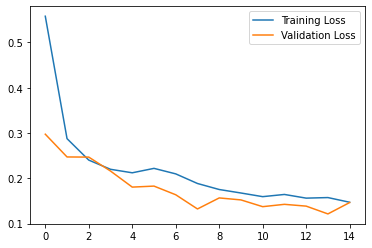

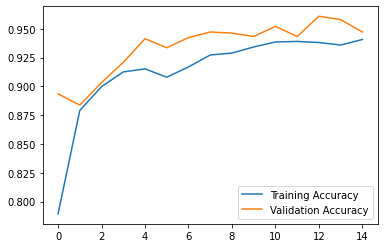

In [15]:
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [16]:
score = model.evaluate(Testing,TestingLabels,verbose=0)
print('Test Accuracy for the Model is', round(score[1]*100),"%")

Test Accuracy for the Model is 88 %


We observe that after training our model we have achieved a 88% accuracy on the testing data. The Loss and Accuracy curve for our model looks decent. However, we must remember that we haven't dealt with the irregularities in the proportion of the Normal and Peunmonia affected Xray, which may cause our model to predict a majority of the image as only Peunmonia affected. Thus, the data must be normalized.  
